# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp, John Townend and El Mestel at [Victoria University of Wellington-Te Herenga Waka](https://www.wgtn.ac.nz) for use by Earth Science graduate students. 

The notebooks cover material that we think will be of particular benefit to those students with little or no previous experience of computer-based data analysis. We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

In 2024, this material will be delivered at the start of Trimester 1 in conjunction with [ESCI451 Active Earth](https://www.wgtn.ac.nz/courses/esci/451). Space permitting, interested students not enrolled in ESCI451 are encouraged to come along too but please contact El, Calum, Finn, or John first.

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| [2A](ESCI451_Module_2A.ipynb) | More complex plotting, introduction to Numpy | Geodetic positions; DFDP-2B temperatures |
| [2B](ESCI451_Module_2B.ipynb) | Using Pandas to load, peruse and plot data | Earthquake catalogue  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; GNSS data |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | Historical temperature records |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with PyGMT | Earthquake catalogue |
| [4B](ESCI451_Module_4B.ipynb) | Gridded data and vectors | Ashfall data and GNSS |
| [Scripting](ESCI451_Module_5A_Scripting.ipynb) | Moving from notebooks to scripts and the command line | - |
| **[Extras](ESCI451_Module_5B_EXTRAS.ipynb)** | **Computing b-values and fourier analysis** | **Earthquake catalogue and Historical Temperature data** |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

---

## Extras

Kia ora you keen bean! This notebook contains extra examples that go beyond some of the basics given in the other notebooks. Some of them are stand-alone examples relevent to specific topics, and others are extended examples of particular nuanced Python things. **You don't need to work through this notebook for ESCI451**, but you might find some of these examples useful in the future.

The examples are:
1. Using pandas to compute time-variations in b-values;
2. Basic Fourier analysis;
3. ... (we may add more!)

---

## 1. Computing b-values

Earthquake generally follow a Gutenberg-Richter relationship, where the logarithm of the cumulative number of earthquakes above a given magnitude is proportional to the magnitude:
\begin{equation}
    \log_{10}{N} = a - bM
\end{equation}
where *M* is magnitude, *N* is the number of events with magnitude >= *M*, and *a* and *b* are constants. This is a nice simple straight-line equation with offset from the origin given by *a* and the gradient by *b*.

Some studies (for example, [Nuannin et al., 2005](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005GL022679)) have found variations in b-value with time and space, and related this to changes in stress.  Lets see if we can:
1. Calculate the b-value for our dataset;
2. Do some sliding-window fu to get at b-value variations in time.

To kick us off, note that in our analysis we are going to miss one fundamental thing which means that everything we do is wrong.  That thing is catalogue completeness, upon which our b-value calculations depend. To show that completeness, and have a first pass at computing b-values, lets look at a cumulative distribution of earthquake magnitudes.

### Plotting cumulative distributions

We want an inverse cumulative plot of magnitudes. We can do this with matplotlib's `hist` by setting the `cumulative` argument to `-1`, and the `density` argument set to `True`:

Using query: https://quakesearch.geonet.org.nz/csv?bbox=172.37,-43.12,174.95,-41.15&minmag=2&maxmag=9.0&mindepth=0.0&maxdepth=500.0&startdate=2010-01-01T00:00:00&enddate=2020-01-01T00:00:00


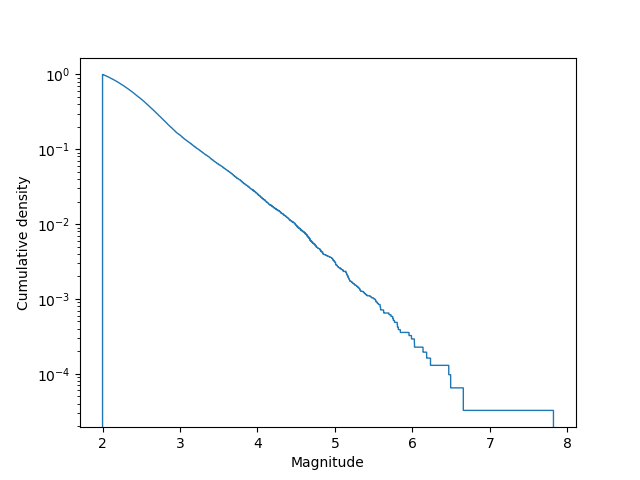

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import datetime
import pandas as pd

from helpers.get_data import get_geonet_quakes

kaikoura = get_geonet_quakes(
    min_latitude=-43.12, max_latitude=-41.15,
    min_longitude=172.37, max_longitude=174.95,
    start_time=datetime.datetime(2010, 1, 1),
    min_magnitude=2)

fig, ax = plt.subplots()
ax.hist(
    kaikoura["magnitude"], bins=len(kaikoura),
    histtype="step", density=True, log=True,
    cumulative=-1)
ax.set_xlabel("Magnitude")
ax.set_ylabel("Cumulative density")
plt.show()

Looks pretty straight on a log-normal plot, as we would expect from the Gutenberg-Richter law.  However, somewhere between M 2 and 3 it stops being straight.  We assume that our catalogue completeness is somewhere in here.  This means that we think that, if we could detect and catalogue all the earthquakes all the way down to the tiny earthquakes, we would continue seeing this log-normal relationship. So, we assume that below our magnitude of completeness ($M_C$) we are missing earthquakes.  This seems reasonable, as earthquakes get smaller they get much harder to detect simply because their amplitudes are greatly reduced.

Lets *assume* our catalogue is complete to $M_C=2.5$ and try and fit a straight line to our cumulative-density plot.

First we will count how many times each magnitude appears in our dataset, we will use a handy object in Pythons native [`collections`](https://docs.python.org/3/library/collections.html) library, called `Counter`:

In [2]:
from collections import Counter

counted_magnitudes = Counter(kaikoura["magnitude"])

# Print the most common 10 magnitudes
print(counted_magnitudes.most_common(10))

[(2.398, 9), (2.508, 9), (2.23, 9), (2.532, 8), (2.549, 8), (2.128, 7), (2.293, 7), (2.147, 7), (2.459, 7), (2.59, 7)]


Cool, that gives us a list of the magnitude and the number of occurrences of that magnitude.  What we actually want is magnitudes and the number of occurrences of that magnitude and *any magnitude above that magnitude*.  To do that we will:
1. create a unique set of all the magnitudes

In [3]:
magnitudes = set(kaikoura["magnitude"])

2. Make a sorted `list` from this set:

In [4]:
magnitudes = sorted(list(magnitudes), reverse=True)

3. Remove all magnitudes below our completeness using a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) (because they are handy):

In [5]:
magnitudes = [m for m in magnitudes if m >= 2.5]

4. Initialise an empty array in which we will put the cumulative density function

In [6]:
import numpy as np

density = np.zeros(len(magnitudes))

5. Loop through the magnitudes from largest to smallest and add the number of occurrences of that magnitude to the total occurrences of the previous magnitude bin:

In [7]:
density[0] = counted_magnitudes[magnitudes[0]]
for i, magnitude in enumerate(magnitudes[1:]):
    density[i + 1] = density[i] + counted_magnitudes[magnitude]

Lets check that that looks okay by plotting it:

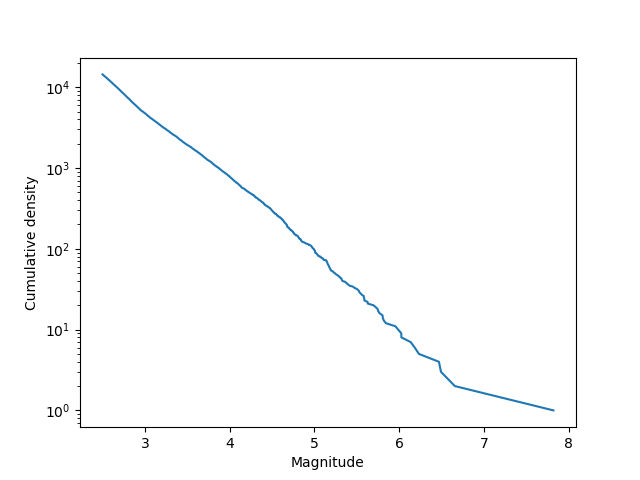

In [8]:
fig, ax = plt.subplots()
ax.semilogy(magnitudes, density)
ax.set_ylabel("Cumulative density")
ax.set_xlabel("Magnitude")
plt.show()

Looks good! Now lets try and fit a line to it.  We can use `numpy`'s solvers to do this. Because this is a nice
simple equation we will use the [numpy.polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) function:

In [9]:
coefficients, residual, rank, singular_values, rcondition = np.polyfit(
    magnitudes, np.log10(density), deg=1, full=True)
b, a = coefficients
print(f"a={a:.2f}, b={b:.2f}")

a=6.27, b=-0.85


b is usually close to 1 (note that the gradient calculated above is negative, which is already taken care of in the Gutenberg-Richter law). 

Lets estimate the density from our calculated values:

In [10]:
# To make our lives easier we will convert our magnitudes to a numpy array:
magnitudes = np.array(magnitudes)
estimated_density = 10 ** (a + (magnitudes * b))

Right, lets see if it fits!

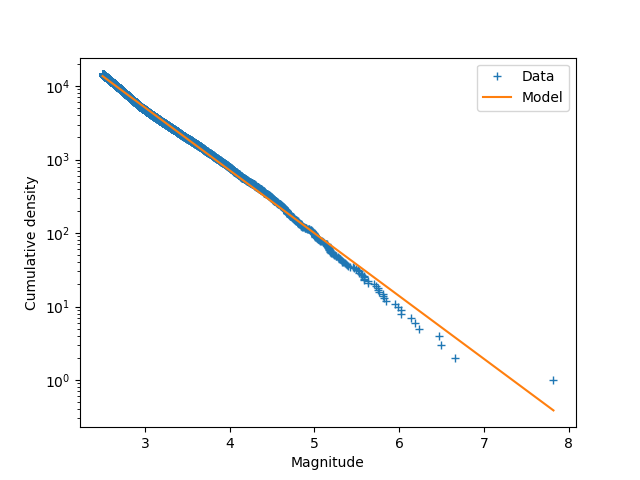

In [11]:
fig, ax = plt.subplots()
ax.semilogy(
    magnitudes, density, marker="+", linestyle="None",
    label="Data")
ax.semilogy(magnitudes, estimated_density, label="Model")
ax.set_ylabel("Cumulative density")
ax.set_xlabel("Magnitude")
ax.legend()
plt.show()

Note that because we specified `full=True` in our call to `polyfit`, we were returned a range of metrics about how well-fitted our data were.  The easiest one of those to understand is the residual:

In [12]:
print(residual)

[7.36381152]


This is a measure of the misfit between our model and our data.

Lets build a simple function to do this with the aim of applying this to distinct time-chunks of our dataset:

In [13]:
def calc_b_value(magnitudes, completeness_magnitude=2.5):
    """
    Calculate the b-value for a range of magnitudes.

    Parameters
    ----------
    magnitudes
        List or array of magnitudes
    completeness_magnitude
        Magnitude of completeness for the dataset

    Returns
    -------
    b-value
    """
    counted_magnitudes = Counter(magnitudes)
    magnitudes = sorted(list(set(magnitudes)), reverse=True)
    magnitudes = np.array(magnitudes)
    # Remove magnitudes less than completess
    magnitudes = magnitudes[magnitudes >= completeness_magnitude]
    # Calculate density
    density = np.zeros(len(magnitudes))
    density[0] = counted_magnitudes[magnitudes[0]]
    for i, magnitude in enumerate(magnitudes[1:]):
        density[i + 1] = density[i] + counted_magnitudes[magnitude]
    coefficients, residual, rank, singular_values, rcondition = np.polyfit(
        magnitudes, np.log10(density), deg=1, full=True)
    b, a = coefficients
    return b

Lets check that we get the same b-value as we did before:

In [14]:
b = calc_b_value(kaikoura["magnitude"])
print(f"b={b:.2f}")

b=-0.85


### Rolling windows with Pandas

Pandas has neat ways of doing rolling windows.  We will use this to do two things:
1. Calculate the median date for every 2000 earthquakes;
2. Calculate the b-value for every 2000 earthquakes.

We will then plot these and see if we see any variations.

To calculate the median date we will:
1. sort the dataframe by `"origintime"`
2. Extract just the `"origintime"` and `"magnitude"` columns

In [15]:
window_size = 2000

kaikoura = kaikoura.sort_values(by=["origintime"], ignore_index=True)
magnitude_times = pd.concat(
    [kaikoura["origintime"], kaikoura["magnitude"]], axis=1)

3. Make a new column containing the seconds since the first event - pandas doesn't have a simple way to calculate the median of a range of datetimes, so we will change to working in seconds since a reference time

In [16]:
seconds_offset = (magnitude_times.origintime -
                  magnitude_times.origintime[0]).dt.total_seconds()
magnitude_times = magnitude_times.merge(
    seconds_offset.rename("seconds_offset"), left_index=True, right_index=True)

4. Compute the rolling median of the seconds_offset column

In [17]:
window_median = magnitude_times.seconds_offset.rolling(window_size).median()

5. Convert this column to timedelta objects

In [18]:
window_median = pd.to_timedelta(window_median, unit="s")  # Unit is seconds

6. Add the reference time to these to get back to real-time

In [19]:
window_median += magnitude_times.origintime[0]

7. Put this into the dataframe as a new column

In [20]:
magnitude_times = magnitude_times.merge(
    window_median.rename("window_median"), left_index=True, right_index=True)

### Computing moving window b-values

Computing the moving b-value is a little simpler to write, but slower to run.  We will use the function we wrote above and pandas `.rolling().apply(func)` chained method to apply our custom `func` to our column:

In [21]:
b_values = magnitude_times.magnitude.rolling(window_size).apply(calc_b_value)

Lets quickly convert those from gradients to b-values by multiplying by -1:

In [22]:
b_values *= -1

Now we can put those back into the dataframe:

In [23]:
magnitude_times = magnitude_times.merge(
    b_values.rename("b_value"), left_index=True, right_index=True)

### Plotting the results

Now lets plot it:

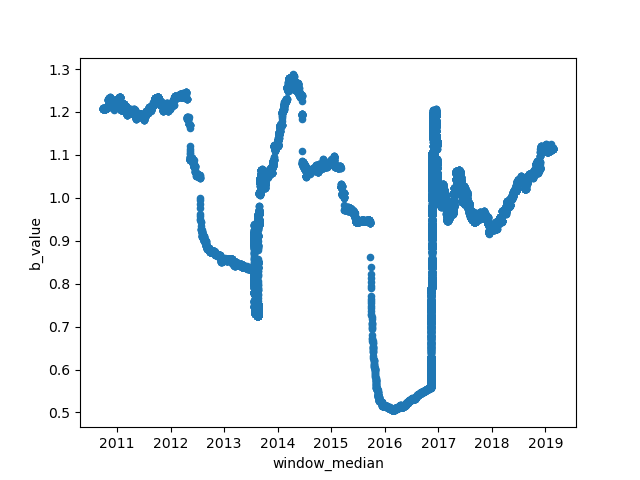

In [24]:
ax = magnitude_times.plot(x="window_median", y="b_value", kind="scatter")

### What next?

There are some pretty impressive variations there! In particular there are strong variations in 2013 and 2016, right around when the Cook Strait and Kaikoura earthquakes happened. I wonder if there is anything in that...? **before we get ahead of ourselves**, we missed some key things here that mean that this result is not interpretable:
1. Not all magnitudes are equal, and we were just using GeoNet's summary magnitude;
2. We fixed the magnitude of completeness when in reality completeness depends on a range of factors and is time-varying;
3. We haven't taken spatial variations into account - we have looked at quite a large region here.

We could get around those factors though and extend our rolling window to compute completeness alongside b-value. Potential student project...?

**Exercise:** Using pandas rolling windows, find the mean earthquake location for every window we used above. You will need to compute the rolling mean for latitude, longitude and depth.  Make three plots to show how latitude, longitude and depth vary with time.

In [25]:
# Your answer here

---

## 2. Basic Fourier analysis using SciPy

We won't go into much detail about how different signal processing tools, not least the workhorse that is the the Fourier Transform, can be applied to time series data in Python. However, the following code illustrates the way in which the obvious annual cyclicity in the CliFlo temperatures can be extracted and illustrated using tools from [SciPy](https://www.scipy.org/). We have defined a function that uses the Fast Fourier Transfrom to isolate the annual signal.

In [26]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt

def parser(date): return dt.strptime(date, '%Y%m%d:%H%M')


T0 = pd.read_csv(
    'data/1939-1989-surface-temperature-CliFlo.csv',
    parse_dates=['Date'], date_format=parser, index_col='Date')
T10 = pd.read_csv(
    'data/1939-1989-10cm-temperature-CliFlo.csv',
    parse_dates=['Date'], date_format=parser, index_col='Date')
T30 = pd.read_csv(
    'data/1939-1989-30cm-temperature-CliFlo.csv',
    parse_dates=['Date'], date_format=parser, index_col='Date')
T100 = pd.read_csv(
    'data/1939-1989-100cm-temperature-CliFlo.csv',
    parse_dates=['Date'], date_format=parser, index_col='Date')

T0['Temperature'] = T0.apply(lambda df: (df['Tmax'] + df['Tmin']) / 2, axis=1)

merged1 = pd.merge(left=T0, right=T10, how='inner',
                   left_on='Date', right_on='Date')
merged1.rename(columns={'Temperature_x': 'T0',
               'Temperature_y': 'T10'}, inplace=True)
merged2 = pd.merge(left=merged1, right=T30, how='inner',
                   left_index=True, right_index=True)
merged2.rename(columns={'Temperature': 'T30'}, inplace=True)
temperatures = pd.merge(left=merged2, right=T100,
                        how='inner', left_index=True, right_index=True)
temperatures.rename(columns={'Temperature': 'T100'}, inplace=True)

In [27]:
from scipy import signal, stats, fftpack
import numpy as np
# https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/


def annular_component(df, column):
    '''
    Analyse spectrum and return reconstruction 
    containing frequencies lower than annual
    '''
    times = df[column].to_numpy()

    freq_amp = fftpack.fft(times)
    power_spectral_density = np.abs(freq_amp) ** 2
    freqs = fftpack.fftfreq(len(power_spectral_density), 1. / 365)
    i = freqs > 0
    freq_amp_copy = freq_amp.copy()
    freq_amp_copy[np.abs(freqs) > 1.01] = 0

    annular = np.real(fftpack.ifft(freq_amp_copy))

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].plot(freqs[i], 10 * np.log10(power_spectral_density[i]), 'o-')
    ax[0].set_xlim(0, 5)
    ax[0].set_xlabel('Frequency (1/year)')
    ax[0].grid()
    ax[0].set_ylabel('PSD (dB)')

    ax[1].plot(df.index, times, label='Raw signal', color='lightgray')
    ax[1].plot(df.index, annular, label='Annual component',
               color='black', linewidth=3)
    ax[1].legend()
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Temperature (C)')

    return annular, fig

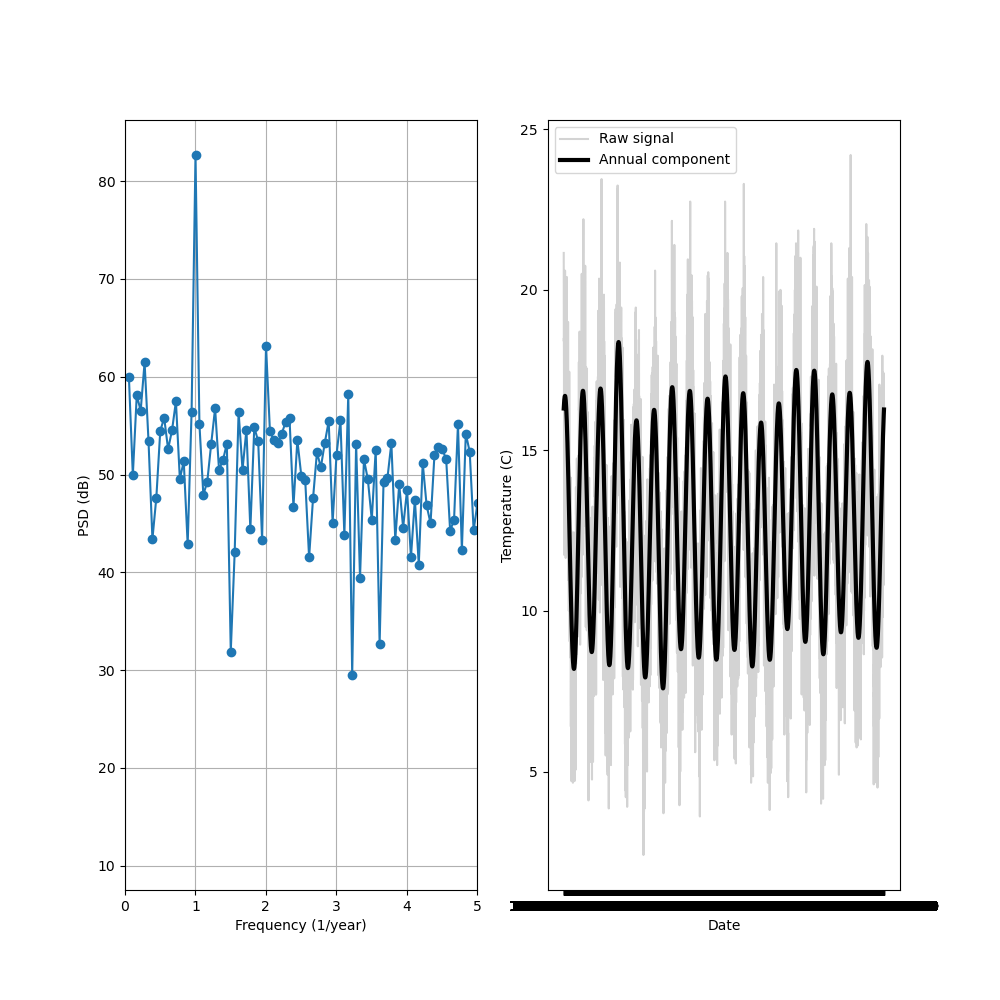

In [28]:
annular, fig = annular_component(temperatures, 'T0')
plt.show()

In [29]:
from scipy import signal, stats, fftpack
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate

t0 = stats.zscore(temperatures['T0'].rolling(
    window=3).mean().to_numpy(na_value=0))
t10 = stats.zscore(temperatures['T10'].rolling(
    window=7).mean().to_numpy(na_value=0))
t30 = stats.zscore(temperatures['T30'].rolling(
    window=7).mean().to_numpy(na_value=0))
t100 = stats.zscore(temperatures['T100'].rolling(
    window=3).mean().to_numpy(na_value=0))

-11


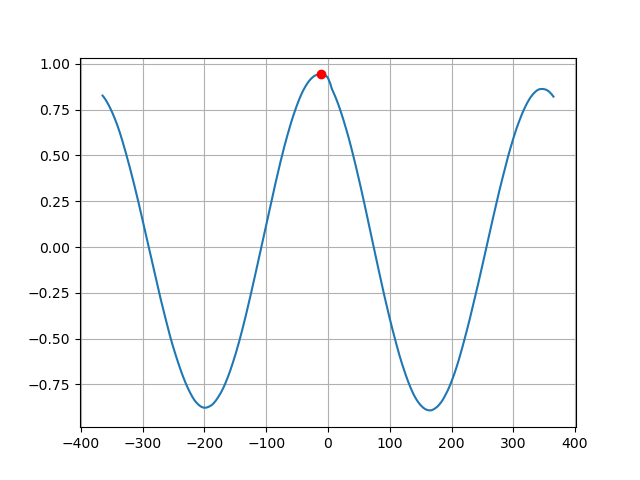

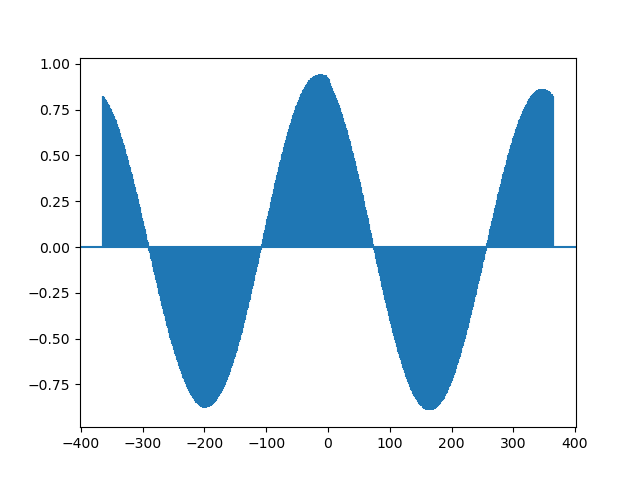

In [30]:
fig, ax = plt.subplots()
corr = ax.xcorr(t10, t100, maxlags=365)
# https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.xcorr.html
l = corr[0]
c = corr[1]
print(l[np.argmax(c)])
fig, ax = plt.subplots()
ax.plot(l, c)
ax.plot(l[np.argmax(c)], np.max(c), 'ro')
ax.grid()
plt.show()